# Pangea Bio Case Study

#### 1.1. Initialise R within python using rpy2

#### 1.2. Python EDA - Raw Data Import and #Spectra

In [154]:
# Initialize R magic (rpy2) for Jupyter Notebook
%load_ext rpy2.ipython 

### Import Python Libraries ###
# Import basic python data and plotting libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Import pyopenms and deps.
import pyopenms as oms
import sys
from pyopenms.plotting import plot_spectrum
from lxml import etree                      
from rdkit import Chem
from rdkit.Chem import Draw

# Import SimMS, MatchMS and deps
from matchms import calculate_scores
from matchms.importing import load_from_mgf
from matchms.filtering import require_correct_ionmode
from matchms.similarity import PrecursorMzMatch
from simms.similarity import CudaCosineGreedy, \
                              CudaModifiedCosine, \
                              CudaFingerprintSimilarity    

# Import NeatMS and deps.
import sys
import logging
import NeatMS as ntms
from  collections import Counter

# Import rpy2 and deps.
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [2]:
%%R
### Import R Libraries ###
library(xcms)
library(MsExperiment)
library(Spectra)
library(CAMERA)

Loading required package: BiocParallel
Loading required package: MSnbase
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    Filter, Find, Map, Position, Reduce, anyDuplicated, aperm, append,
    as.data.frame, basename, cbind, colnames, dirname, do.call,
    duplicated, eval, evalq, get, grep, grepl, intersect, is.unsorted,
    lapply, mapply, match, mget, order, paste, pmax, pmax.int, pmin,
    pmin.int, rank, rbind, rownames, sapply, setdiff, sort, table,
    tapply, union, unique, unsplit, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignettes()'. To cite Bioconductor, see
    'citation("Biobase")', and for packages 'citation("pkgname")'.

Loading required package: mzR
Loading required package: Rcpp
Loading required 

In [ ]:
## Test GPU environment.
gpu = ! nvidia-smi
print("\n".join(gpu))

In [3]:
# Load the mzXML files
extract = oms.MSExperiment()
oms.MzXMLFile().load("sync/Data/mzXML/extract.mzXML", extract)
blank = oms.MSExperiment()
oms.MzXMLFile().load("sync/Data/mzXML/blank.mzXML", blank)

# Print the number of spectra in each file
print(f"Extract #Spectra = {extract.getNrSpectra()}")
print(f"Blank #Spectra = {blank.getNrSpectra()}")

# Check scan polarity
extract_acq_polarity = pd.Series([(spec.getInstrumentSettings().getPolarity()) for spec in extract])
print(f"Extract spectra polarity value counts:\n {extract_acq_polarity.value_counts()}\n")
blank_acq_polarity = pd.Series([(spec.getInstrumentSettings().getPolarity()) for spec in blank])
print(f"Blank spectra polarity value counts:\n {blank_acq_polarity.value_counts()}")

Extract #Spectra = 14163
Blank #Spectra = 14158
Extract spectra polarity value counts:
 1    14163
Name: count, dtype: int64

Blank spectra polarity value counts:
 1    14158
Name: count, dtype: int64


All spectra were acquired under +ve ionisation (with manual reference two the mzXML file).

#### 1.3. Python EDA - Total Ion Chromatograms

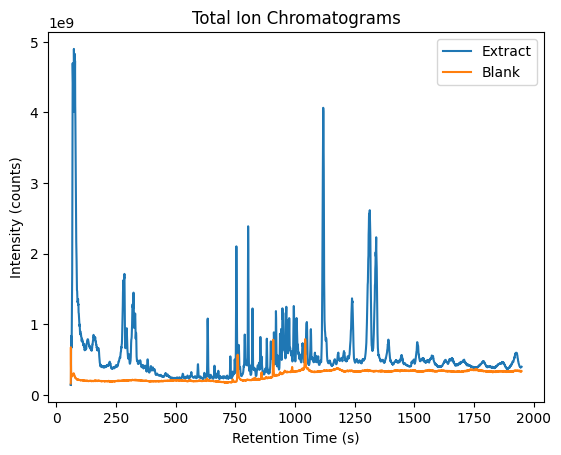

In [4]:
# Extract TIC data looping over spectra in MSExperiment()
RT_extract = []
I_extract = []
for spec in extract:
    if spec.getMSLevel() == 1:
        RT_extract.append(spec.getRT())
        I_extract.append(sum(spec.get_peaks()[1]))

# Blank TIC data looping over spectra in MSExperiment()
RT_blank = []
I_blank = []
for spec in blank:
    if spec.getMSLevel() == 1:
        RT_blank.append(spec.getRT())
        I_blank.append(sum(spec.get_peaks()[1]))

# Create a pandas DataFrame
TIC_df_extract = pd.DataFrame({'RT_extract': RT_extract, 'I_extract': I_extract})
TIC_df_blank = pd.DataFrame({'RT_blank': RT_blank, 'I_blank': I_blank})

# Plot the TIC data
sns.lineplot(x=RT_extract, y=I_extract, data=TIC_df_extract, label="Extract")
sns.lineplot(x=RT_blank, y=I_blank, data=TIC_df_blank, label="Blank")
plt.title("Total Ion Chromatograms")
plt.xlabel("Retention Time (s)")
plt.ylabel("Intensity (counts)")
plt.show()

#### 1.4. Python EDA - XIC 298.0967

/home/dockeruser/venv/lib/python3.12/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))


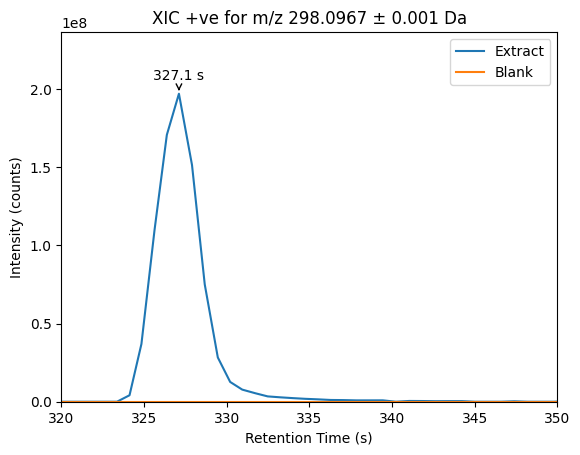

In [5]:
extract_ms1 = oms.MSExperiment()
for spec in extract.getSpectra():
    if spec.getMSLevel() == 1:
        extract_ms1.addSpectrum(spec)
        
blank_ms1 = oms.MSExperiment()
for spec in blank.getSpectra():
    if spec.getMSLevel() == 1:
        blank_ms1.addSpectrum(spec)

mz_value = 298.0967
mz_window = 0.001  # Total window size (± Da)

transition = oms.ReactionMonitoringTransition()
transition.setPrecursorMZ(mz_value)
transition.setProductMZ(mz_value)  # For MS1, precursor and product m/z are the same
transition.setLibraryIntensity(1.0)
transition.setNativeID(f"XIC {mz_value}@{mz_value} +ve")

targeted_exp = oms.TargetedExperiment()
targeted_exp.addTransition(transition)

extractor = oms.ChromatogramExtractor()
extract_298_0967 = oms.MSExperiment()
extractor.extractChromatograms(
    extract_ms1,  # Input experiment
    extract_298_0967,  # Output experiment to store chromatograms
    targeted_exp,  # Targeted experiment with transitions
    mz_window,  # Extraction window
    False,  # Use ppm (False means Da)
    oms.TransformationDescription(),  # No RT transformation
    -1,  # Extract over the full RT range
    "tophat"  # Extraction filter
)

extractor = oms.ChromatogramExtractor()
blank_298_0967 = oms.MSExperiment()
extractor.extractChromatograms(
    blank_ms1,  # Input experiment
    blank_298_0967,  # Output experiment to store chromatograms
    targeted_exp,  # Targeted experiment with transitions
    mz_window,  # Extraction window
    False,  # Use ppm (False means Da)
    oms.TransformationDescription(),  # No RT transformation
    -1,  # Extract over the full RT range
    "tophat"  # Extraction filter
)

extract_xic_298_0967 = extract_298_0967.getChromatogram(0)
extract_rt, extract_intensity = extract_xic_298_0967.get_peaks()
extract_xic_298_0967_df = pd.DataFrame({'RT': extract_rt, 'Intensity': extract_intensity})
extract_xic_298_0967_df_IMax = extract_xic_298_0967_df["Intensity"].max()
extract_xic_298_0967_df_RTMax = extract_xic_298_0967_df["RT"][extract_xic_298_0967_df["Intensity"]==extract_xic_298_0967_df_IMax]

blank_xic_298_0967 = blank_298_0967.getChromatogram(0)
blank_rt, blank_intensity = blank_xic_298_0967.get_peaks()


sns.lineplot(x=extract_rt, y=extract_intensity, label="Extract")
sns.lineplot(x=blank_rt, y=blank_intensity, label="Blank")
plt.xlabel("Retention Time (s)")
plt.ylabel("Intensity (counts)")
plt.xlim(320, 350)
plt.ylim(0, 1.2*extract_xic_298_0967_df_IMax)
plt.annotate(f"{extract_xic_298_0967_df_RTMax.values[0].round(1)} s", [extract_xic_298_0967_df_RTMax, extract_xic_298_0967_df_IMax], textcoords="offset points", xytext=(0,10), ha='center', arrowprops=dict(arrowstyle="->"))
plt.title(f"XIC +ve for m/z {mz_value} ± {mz_window} Da")
plt.show()

#### 1.5. View representative MS1 and MS2 spectra for m/z 298.0967 @ 327.1 s

Found MS1 spectrum at retention time: 327.116
m/z values: [ 67.05500793  67.56723022  67.5681076  ... 700.40618896 722.24298096
 969.48858643]
Intensities: [368812.1    50700.676  80144.11  ... 128943.516  75274.53   38029.996]


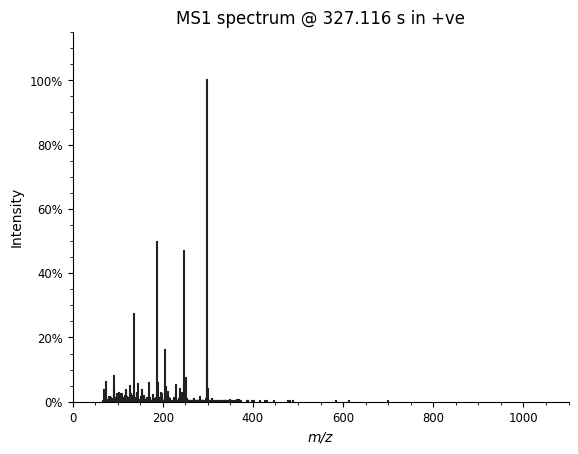

Found MS2 spectrum with precursor m/z: 298.096650065991
m/z values: [ 50.87759399  61.01138306  69.03425598  70.27145386  70.27484894
  75.02695465  76.76761627  87.4163208   94.04051208  97.02875519
 103.02152252 119.03531647 122.27677917 124.70940399 136.0617218
 137.04560852 145.03207397 163.04240417 212.5241394  246.25497437
 298.09640503 306.00265503 310.4552002 ]
Intensities: [  29493.125  636334.2     34670.797   73160.41    49341.387  258325.94
   31446.105   31080.498  113251.18   134732.27    63383.96   283832.75
   39659.844   30980.148 7878598.5    218107.6     86819.29   118088.15
   35235.973   30945.379  465111.16    30170.807   36287.965]


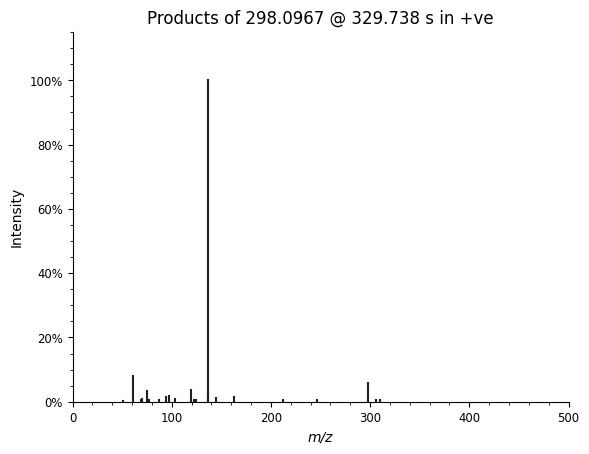

MS2 Spectrum Information:
Retention Time: 329.738
Number of Peaks: 23
Precursor m/z: 298.096650065991
Precursor Intensity: 28298092.0
50.877593994140625, 29493.125
61.011383056640625, 636334.1875
69.03425598144531, 34670.796875
70.27145385742188, 73160.40625
70.27484893798828, 49341.38671875
75.0269546508789, 258325.9375
76.76761627197266, 31446.10546875
87.41632080078125, 31080.498046875
94.04051208496094, 113251.1796875
97.02875518798828, 134732.265625
103.02152252197266, 63383.9609375
119.03531646728516, 283832.75
122.27677917480469, 39659.84375
124.70940399169922, 30980.1484375
136.0617218017578, 7878598.5
137.0456085205078, 218107.59375
145.03207397460938, 86819.2890625
163.0424041748047, 118088.1484375
212.52413940429688, 35235.97265625
246.25497436523438, 30945.37890625
298.0964050292969, 465111.15625
306.0026550292969, 30170.806640625
310.4552001953125, 36287.96484375
Collision Energy: None


In [6]:
# Desired retention time
target_rt = 327.1

# Find the MS1 spectrum closest to the target retention time
closest_spectrum = None
closest_rt_diff = float('inf')

for spectrum in extract:
    if spectrum.getMSLevel() == 1:  # Ensure it's an MS1 spectrum
        rt = spectrum.getRT()
        rt_diff = abs(rt - target_rt)
        if rt_diff < closest_rt_diff:
            closest_rt_diff = rt_diff
            closest_spectrum = spectrum

# Check if a spectrum was found
if closest_spectrum is not None:
    print(f"Found MS1 spectrum at retention time: {closest_spectrum.getRT()}")
    mz, intensity = closest_spectrum.get_peaks()
    print("m/z values:", mz)
    print("Intensities:", intensity)
else:
    print("No MS1 spectrum found close to the target retention time.")
    
plot_spectrum(closest_spectrum, annotate_ions=True)
plt.title(f"MS1 spectrum @ {np.round(closest_spectrum.getRT(), 3)} s in +ve")
plt.show()

# Find the MS2 spectrum with the precursor m/z closest to 298.0967
closest_ms2_spectrum = None
closest_mz_diff = float('inf')

for spectrum in extract:
    if spectrum.getMSLevel() == 2:  # Ensure it's an MS2 spectrum
        precursors = spectrum.getPrecursors()
        if precursors:
            precursor_mz = precursors[0].getMZ()
            mz_diff = abs(precursor_mz - mz_value)
            if mz_diff < closest_mz_diff:
                closest_mz_diff = mz_diff
                closest_ms2_spectrum = spectrum

# Check if a spectrum was found
if closest_ms2_spectrum is not None:
    print(f"Found MS2 spectrum with precursor m/z: {closest_ms2_spectrum.getPrecursors()[0].getMZ()}")
    mz, intensity = closest_ms2_spectrum.get_peaks()
    print("m/z values:", mz)
    print("Intensities:", intensity)
else:
    print("No MS2 spectrum found with the precursor m/z close to 298.0967.")
    
plot_spectrum(closest_ms2_spectrum, annotate_ions=True)
plt.title(f"Products of {np.round(closest_ms2_spectrum.getPrecursors()[0].getMZ(), 4)} @ {np.round(closest_ms2_spectrum.getRT(), 3)} s in +ve")
plt.show()

display(closest_ms2_spectrum)
# Display information about the closest MS2 spectrum
print(f"MS2 Spectrum Information:")
print(f"Retention Time: {closest_ms2_spectrum.getRT()}")
print(f"Number of Peaks: {closest_ms2_spectrum.size()}")
print(f"Precursor m/z: {closest_ms2_spectrum.getPrecursors()[0].getMZ()}")
print(f"Precursor Intensity: {closest_ms2_spectrum.getPrecursors()[0].getIntensity()}")

ms2 = pd.DataFrame({'mz': mz.tolist(), 'intensity': intensity.tolist()})
for i in range(0, len(ms2)):
    print(f"{ms2['mz'][i]}, {ms2['intensity'][i]}")
    
print(f"Collision Energy: {closest_ms2_spectrum.getInstrumentSettings().getMetaValue('collisionEnergy')}")



#### 1.6. Get collision energies

In [7]:
# Extract scan number of the closest MS2 spectrum
scan_number_target = closest_ms2_spectrum.getNativeID()
print(f"Scan number of the closest MS2 spectrum: {scan_number_target}")


# Load the mzXML file
mzxml_file = "sync/Data/mzXML/extract.mzXML"

# Parse the XML file
tree = etree.parse(mzxml_file)
root = tree.getroot()

# Define the mzXML namespace (update this if your mzXML file uses a different namespace)
namespace = {"mzxml": "http://sashimi.sourceforge.net/schema_revision/mzXML_3.2"}

# Example: Extract scan metadata

rows = []
for scan in root.findall(".//mzxml:scan", namespaces=namespace):
    scan_number = scan.get("num")
    ms_level = scan.get("msLevel")
    retention_time = scan.get("retentionTime")
    polarity = scan.get("polarity")
    centroided = scan.get("centroided")
    collisionEnergy = scan.get("collisionEnergy")
    lowMz = scan.get("lowMz")
    highMz = scan.get("highMz")
    basePeakMz = scan.get("basePeakMz")
    basePeakIntensity = scan.get("basePeakIntensity")
    totIonCurrent = scan.get("totIonCurrent")
    rows.append({
    'scan_number': scan_number,
    'ms_level': ms_level,
    'retention_time': retention_time,
    'polarity': polarity,
    'centroided': centroided,
    'collisionEnergy': collisionEnergy,
    'lowMz': lowMz,
    'highMz': highMz,
    'basePeakMz': basePeakMz,
    'basePeakIntensity': basePeakIntensity,
    'totIonCurrent': totIonCurrent,
    })
    for subchild in scan:
        if subchild.tag == "{http://sashimi.sourceforge.net/schema_revision/mzXML_3.2}precursorMz":
            precursorScanNum = subchild.get("precursorScanNum")
            precursorCharge = subchild.get("precursorCharge")
            precursorIntensity = subchild.get("precursorIntensity")
            activationMethod = subchild.get("activationMethod")
            windowWideness = subchild.get("windowWideness")
            precursor_mz = subchild.text
            rows[-1].update({
            'precursor_mz': precursor_mz,
            'precursorScanNum' : precursorScanNum,
            'precursorCharge': precursorCharge,
            'precursorIntensity': precursorIntensity,
            'activationMethod': activationMethod,
            'windowWideness': windowWideness,
            })
            


df = pd.concat([pd.DataFrame([row]) for row in rows], ignore_index=True)
df[df["scan_number"] == scan_number_target]
display(df.head())



## Next steps:
# match the spectrum against a suitable database API, like HMDB or METLIN.
# do the untargetted pipeline in xcms > neatms > simms.
# write the methodology plan.
# start putting together some slides.
# refactor, tidy up and comment the code, remove private info and make open source.



Scan number of the closest MS2 spectrum: scan=2049


,scan_number,ms_level,retention_time,polarity,centroided,collisionEnergy,lowMz,highMz,basePeakMz,basePeakIntensity,totIonCurrent,precursor_mz,precursorScanNum,precursorCharge,precursorIntensity,activationMethod,windowWideness
0,1,1,PT60.113S,+,1,None,67.018684387207,978.303649902344,108.0812,2.0544386e07,1.6624422e08,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,PT60.5526S,+,1,None,67.055084228516,947.077697753906,108.0812,2.1804648e07,1.7960768e08,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,PT60.9003S,+,1,None,67.055053710938,877.778198242188,108.0812,2.4255664e07,1.7447182e08,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,PT61.248S,+,1,None,67.055053710938,775.935546875,108.0812,2.4262048e07,1.7012784e08,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,PT61.5684S,+,1,None,67.055076599121,969.711853027344,74.09715671,5.1385224e07,4.343911e08,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
closest_ms2_spectrum

In [9]:
###########################################################################
## Example script to convert any file to MGF
# Adapted from https://github.com/OpenMS/pyopenms-docs/blob/master/src/examples/convertToMGF.py
###########################################################################

# Load the input MSExperiment
msdata = oms.MSExperiment()
msdata.addSpectrum(closest_ms2_spectrum)

# Read input
with open("sync/Output/output_spectrum.mgf", "w") as outfile:
    # Create header
    outfile.write("COM=Testfile\n")
    outfile.write("ITOL=1\n")
    outfile.write("ITOLU=Da\n")
    outfile.write("CLE=Trypsin\n")
    outfile.write("CHARGE=1,2,3\n")

    # Iterate through all spectra, skip all MS1 spectra and then write mgf format
    nr_ms2_spectra = 0
    for spectrum in msdata:
        if spectrum.getMSLevel() == 1:
            continue
        nr_ms2_spectra += 1
        outfile.write("\nBEGIN IONS\n")
        outfile.write("TITLE=%s\n" % spectrum.getNativeID())
        outfile.write("RTINSECONDS=%s\n" % spectrum.getRT())
        try:
            outfile.write("PEPMASS=%s\n" % spectrum.getPrecursors()[0].getMZ())
            ch = spectrum.getPrecursors()[0].getCharge()
            if ch > 0:
                outfile.write("CHARGE=%s\n" % ch)
        except IndexError:
            outfile.write("PEPMASS=unknown\n")
        for peak in spectrum:
            outfile.write("%s %s\n" % (peak.getMZ(), peak.getIntensity() ))
        outfile.write("END IONS\n")

    if nr_ms2_spectra == 0:
        print("Did not find any MS2 spectra in your input, thus the output file is empty!")


In [10]:
references = list(load_from_mgf("sync/Spectral_Databases/20250125_ALL_GNPS.mgf"))
queries = list(load_from_mgf("sync/Output/output_spectrum.mgf"))

# Define the similarity function
similarity_function = CudaCosineGreedy(
    tolerance=0.1,  # Same parameters as CosineGreedy
    mz_power=0,
    intensity_power=1,
    shift=0,
    ## CUDA-specific parameters!
    ## Controls the number of reference/queries to process in one step
    # larger batch sizes might speed up processing if GPU has enough memory
    batch_size=4096,
    # We need to trim any spectra with many peaks to maximum of `n_max_peaks`
    # shorter spectra aren't affected.
    n_max_peaks=1024,
    # Match limit is the number of possible pairs we accumulate before peak deduplication
    # In practice, match limits over 2k have negligible accuracy improvement.
    match_limit=2048,
    # Only used when array_type is 'sparse'. With sparse, we discard all scores
    # that are smaller than `sparse_threshold`. This allows us to save RAM memory
    # from overflowing when processing pairs on the order of ~1e+10.
    sparse_threshold=0.75,
)

# Calculate scores
scores = calculate_scores( 
  references=references,
  queries=queries,
  similarity_function=similarity_function, 
)



[(0.9990752, 12, False), (0.99880207, 12, False), (0.99873066, 12, False), (0.99826765, 12, False), (0.99808234, 12, False)]
<class 'matchms.Scores.Scores'>


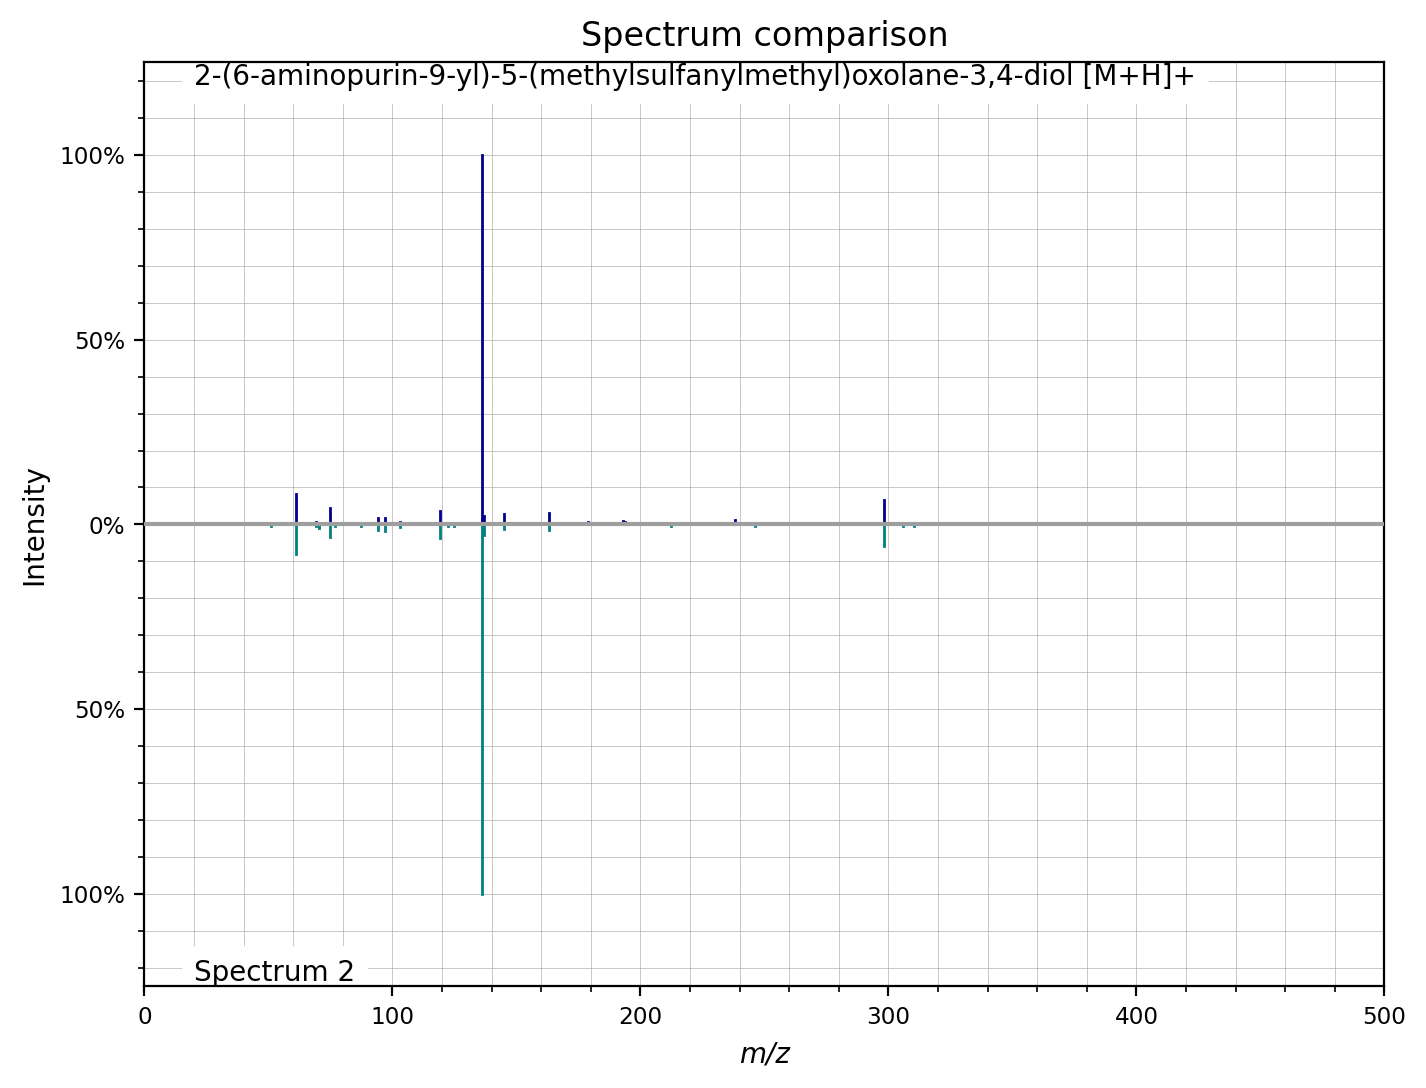

In [11]:
best_matches = scores.scores_by_query(queries[0], name="CudaCosineGreedy_score", sort=True)[:5]
print([x[1] for x in best_matches])
[x[0].get("smiles") for x in best_matches]

print(type(scores))



for i, smiles in enumerate([x[0].get("smiles") for x in    best_matches]):
    if smiles != None:
        m = Chem.MolFromSmiles(smiles)
        Draw.MolToFile(m, f"sync/Output/compound_{i}.png")
    else:
        pass

best_matches[0][0].plot_against(queries[0], annotate_ions=True)
plt.show()

In [13]:
%%R
## XCMS Data Import and Initial EDA steps.
# Get the list of files in the ~/sync/Data directory
file_list <- list.files(path = "~/sync/Data/mzXML", full.names = TRUE)

# Define a data.frame with additional information on these files.
sample_metadata <- data.frame(file = basename(file_list),
                 sample = c("blank", "extract"))

# Import the data of the experiment
sample_data <- readMsExperiment(file_list, sampleData = sample_metadata)

# Subset the data
sample_data_blank <- sample_data[1]
sample_data_extract <- sample_data[2]

# Extract sample information
sampleData(sample_data_extract)

# Display sample spectra table
print(spectra(sample_data_blank))
print(spectra(sample_data_extract))


MSn data (Spectra) with 14158 spectra in a MsBackendMzR backend:
        msLevel     rtime scanIndex
      <integer> <numeric> <integer>
1             1   60.1037         1
2             1   60.5355         2
3             1   60.8529         3
4             1   61.1703         4
5             1   61.4918         5
...         ...       ...       ...
14154         2   1949.47     14154
14155         1   1949.60     14155
14156         2   1949.86     14156
14157         2   1949.97     14157
14158         2   1950.05     14158
 ... 33 more variables/columns.

file(s):
blank.mzXML
MSn data (Spectra) with 14163 spectra in a MsBackendMzR backend:
        msLevel     rtime scanIndex
      <integer> <numeric> <integer>
1             1   60.1130         1
2             1   60.5526         2
3             1   60.9003         3
4             1   61.2480         4
5             1   61.5684         5
...         ...       ...       ...
14159         2   1949.57     14159
14160         2   1949.6

In [14]:
%%R 
spectra(sample_data) |>
    spectraVariables()

 [1] "msLevel"                  "rtime"                   
 [3] "acquisitionNum"           "scanIndex"               
 [5] "dataStorage"              "dataOrigin"              
 [7] "centroided"               "smoothed"                
 [9] "polarity"                 "precScanNum"             
[11] "precursorMz"              "precursorIntensity"      
[13] "precursorCharge"          "collisionEnergy"         
[15] "isolationWindowLowerMz"   "isolationWindowTargetMz" 
[17] "isolationWindowUpperMz"   "peaksCount"              
[19] "totIonCurrent"            "basePeakMZ"              
[21] "basePeakIntensity"        "ionisationEnergy"        
[23] "lowMZ"                    "highMZ"                  
[25] "mergedScan"               "mergedResultScanNum"     
[27] "mergedResultStartScanNum" "mergedResultEndScanNum"  
[29] "injectionTime"            "filterString"            
[31] "spectrumId"               "ionMobilityDriftTime"    
[33] "scanWindowLowerLimit"     "scanWindowUpperLimit"  

In [15]:
%%R
print("Blank - spectra per MS level") 
print(table(spectra(sample_data_blank)$msLevel))
    
print("Extract - spectra per MS level") 
print(table(spectra(sample_data_extract)$msLevel))

[1] "Blank - spectra per MS level"

    1     2 
 2401 11757 
[1] "Extract - spectra per MS level"

    1     2 
 2377 11786 


In [16]:
%%R
# Get the distribution of peak counts per spectrum.
spectra(sample_data) |>
    lengths() |>
    split(fromFile(sample_data)) |>
    lapply(quantile)

$`1`
     0%     25%     50%     75%    100% 
   3.00   16.00   25.00   38.75 2635.00 

$`2`
  0%  25%  50%  75% 100% 
   2   21   36   68 2435 



Object of class:  CentWaveParam 
 Parameters:
 - ppm: [1] 25
 - peakwidth: [1] 20 50
 - snthresh: [1] 10
 - prefilter: [1]   3 100
 - mzCenterFun: [1] "wMean"
 - integrate: [1] 1
 - mzdiff: [1] -0.001
 - fitgauss: [1] FALSE
 - noise: [1] 0
 - verboseColumns: [1] FALSE
 - roiList: list()
 - firstBaselineCheck: [1] TRUE
 - roiScales: numeric(0)
 - extendLengthMSW: [1] FALSE
Object of class:  CentWaveParam 
 Parameters:
 - ppm: [1] 15
 - peakwidth: [1]  2 10
 - snthresh: [1] 20
 - prefilter: [1]   3 100
 - mzCenterFun: [1] "wMean"
 - integrate: [1] 2
 - mzdiff: [1] -0.001
 - fitgauss: [1] FALSE
 - noise: [1] 5e+05
 - verboseColumns: [1] FALSE
 - roiList: list()
 - firstBaselineCheck: [1] TRUE
 - roiScales: numeric(0)
 - extendLengthMSW: [1] FALSE
          rt   rtmin   rtmax      into      intb      maxo  sn row column
[1,] 327.116 323.368 337.867 620867875 617817739 196899632 700   1      2


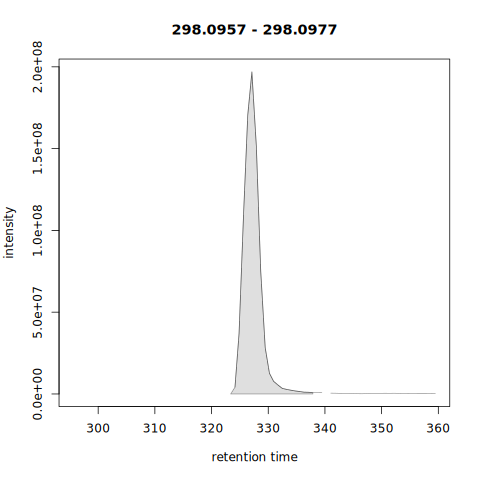

In [20]:
%%R
## XCMS Determine and set centWave peak detection parameters
# Get default centWave parameters
cwp <- CentWaveParam()

# "dry-run" peak detection on the EIC.
res <- findChromPeaks(target_chr, param = cwp)
chromPeaks(res)

# Default centWave parameters
print(cwp)

# Plot the EIC
plot(target_chr)

# Adapt centWave parameters
cwp <- CentWaveParam(peakwidth = c(2, 10), integrate = 2, ppm = 15, noise = 500000, snthresh = 20)
print(cwp)

# Run peak detection on the EIC
target_chr <- findChromPeaks(target_chr, param = cwp)

# Plot the data and higlight identified peak area
plot(target_chr)

# Extract identified chromatographic peaks from the EIC
chromPeaks(target_chr)

In [22]:
%%R
## XCMS Peak Detection
#' Perform peak detection on the full data set
sample_data <- findChromPeaks(sample_data, param = cwp)
sample_data

Object of class XcmsExperiment 
 Spectra: MS1 (4778) MS2 (23543) 
 Experiment data: 2 sample(s)
 Sample data links:
  - spectra: 2 sample(s) to 28321 element(s).
 xcms results:
  - chromatographic peaks: 5819 in MS level(s): 1 


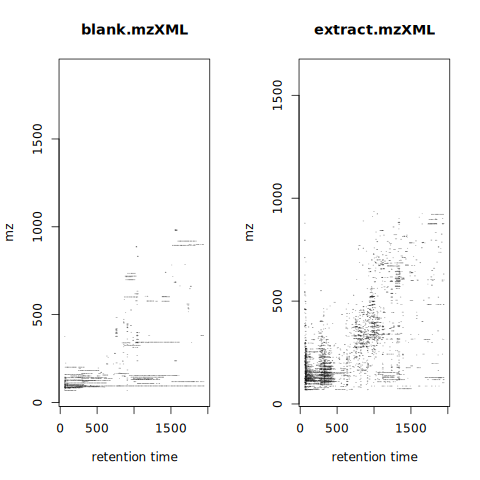

In [24]:
%%R
## XCMS 2D maps
#' Count peaks per file
table(chromPeaks(sample_data)[, "sample"])

#' Plot the location of peaks in the m/z - rt plane
par(mfrow = c(1, 2))
plotChromPeaks(sample_data, 1)
plotChromPeaks(sample_data, 2)

          rtmin    rtmax    mzmin    mzmax
CP1906  62.0191  87.6825 296.1281 296.1392
CP3555 381.5880 411.9610 155.0653 155.0753
CP2911 290.3990 317.7600 136.9847 136.9947
CP0139 183.4650 209.0780 128.0375 128.0475


Processing chromatographic peaks


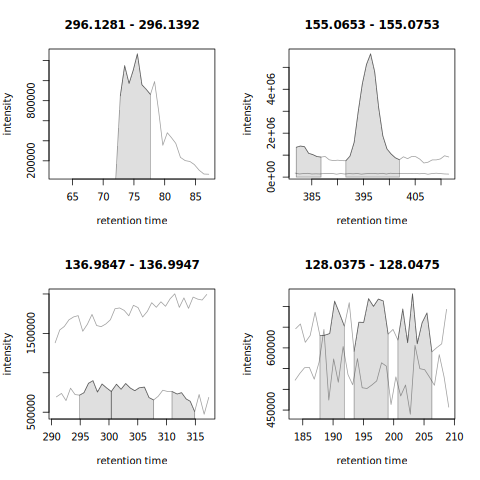

In [25]:
%%R
## XCMS Evaluate Peak Detection
#' Select 4 random peaks
npeaks <- nrow(chromPeaks(sample_data))
idx <- sample(seq_len(npeaks), 4)

#' Extract m/z-rt regions for 4 random peaks
mz_rt <- chromPeaks(sample_data)[idx, c("rtmin", "rtmax", "mzmin", "mzmax")]

#' Expand the rt range by 10 seconds on both sides
mz_rt[, "rtmin"] <- mz_rt[, "rtmin"] - 10
mz_rt[, "rtmax"] <- mz_rt[, "rtmax"] + 10
#' Expand the m/z range by 0.005 on both sides
mz_rt[, "mzmin"] <- mz_rt[, "mzmin"] - 0.005
mz_rt[, "mzmax"] <- mz_rt[, "mzmax"] + 0.005

#' Display the randomly selected regions
print(mz_rt)

#' Define m/z - retention time regions for EICs
# mz_rt <- rbind(c(106.045, 106.055, 165, 195),
#                c(132.096, 132.107, 135, 160),
#                c(125.981, 125.991, 195, 215),
#                c(105.468, 105.478, 190, 215))

#' Extract the EICs
eics <- chromatogram(sample_data, mz = mz_rt[, c("mzmin", "mzmax")], rt = mz_rt[, c("rtmin", "rtmax")])
#' Plot the EICs
plot(eics)

## data very noisy when picking random peaks at 100K threshold, trying 200K

XChromatograms with 4 rows and 2 columns
                   1               2
     <XChromatogram> <XChromatogram>
[1,]        peaks: 0        peaks: 1
[2,]        peaks: 0        peaks: 2
[3,]        peaks: 0        peaks: 1
[4,]        peaks: 1        peaks: 0
phenoData with 3 variables
featureData with 4 variables
- - - xcms preprocessing - - -
Chromatographic peak detection:
 method: centWave 


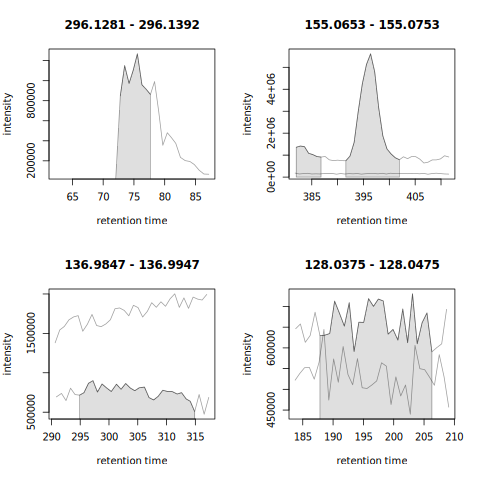

In [26]:
%%R
## XCMS Peak Refinement - Inital Tests
# Define the setting for the peak refinement
mpp <- MergeNeighboringPeaksParam(expandRt = 4, minProp = 0.75)

# Perform the peak refinement on the EICs
eics <- refineChromPeaks(eics, param = mpp)

# Plot the result
plot(eics)
eics

In [27]:
%%R
## XCMS Peak Refinement - Full Data Set
# Perform peak refinement on the full data set
sample_data <- refineChromPeaks(sample_data, param = mpp)

chromPeaks(sample_data)[, "sample"] |>
    table()

# No. of merged peaks    
sum(chromPeakData(sample_data)$merged)

[1] 921


Reduced from 5819 to 3441 chromatographic peaks.


In [29]:
%%R
# XCMS Initial Peak Grouping

# Define the parameters for the peak density estimation
pdp <- PeakDensityParam(sampleGroups = c(0, 1), bw = 1.8,
                        minFraction = 0, binSize = 0.01)
sample_data <- groupChromPeaks(sample_data, pdp)

# Get the anchor peaks that would be selected
pgm <- adjustRtimePeakGroups(sample_data, PeakGroupsParam(minFraction = 1))

       blank.mzXML extract.mzXML
FT0005     63.1432       60.9003
FT1663     74.0104       77.0102
FT0234     92.4155       92.5014
FT0691    130.0100      129.7350
FT1152    165.3790      166.6040
FT1182    583.8660      586.5330
FT1633    631.5690      628.9910
FT1904    631.5690      628.9910
FT1629    638.6310      638.3830
FT1141    726.3570      725.8970
FT1980    738.6290      737.8400
FT1989    738.6290      737.8400
FT1669    759.7770      759.8790
FT2533    759.7770      759.8790
FT2541    759.7770      759.8790
FT2607    759.7770      759.8790
FT2619    759.7770      759.8790
FT2641    759.7770      759.8790
FT2855    759.7770      759.8790
FT1476    799.6450      799.8600
FT1745    846.2790      847.6160
FT1749    846.2790      847.6160
FT1632    857.6110      858.7260
FT2275    860.0220      861.1350
FT2791    860.0220      861.1350
FT2838    860.0220      861.1350
FT0998    872.1250      873.1600
FT0999    878.5490      879.6900
FT1181    878.5490      879.6900
FT2339    

Performing retention time correction using 3373 peak groups.


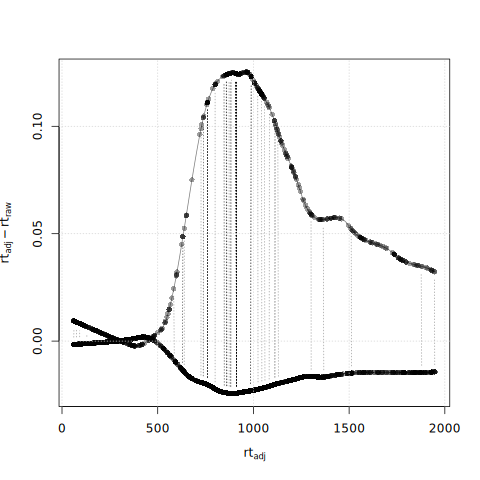

In [30]:
%%R
# XCMS RT Correction

# Define settings for the alignment
pgp <- PeakGroupsParam(minFraction = 0.5, span = 0.6)
sample_data <- adjustRtime(sample_data, param = pgp)

# Plot the difference between raw and adjusted retention times
plotAdjustedRtime(sample_data)
grid()

       blank.mzXML extract.mzXML
FT0001          NA      14647620
FT0002          NA      26600300
FT0003          NA       2629211
FT0004     9238292       7994443
FT0005    80174981       7903664
FT0006          NA    3151122272


Processing chromatographic peaks


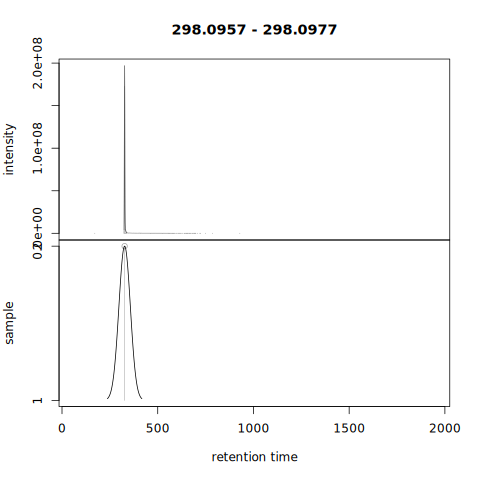

In [32]:
%%R
## XCMS Correspondence Analysis
# Set parameters for correspondence analysis.
pdp <- PeakDensityParam(sampleGroups = c(0, 1), bw = 1.8,
                        minFraction = 0, binSize = 0.005)

# Perform the correspondence analysis on the full data
sample_data <- groupChromPeaks(sample_data, param = pdp)

# Definition of the features
featureDefinitions(sample_data) |>
    head()
    
# Get abundances for the first 6 features
featureValues(sample_data, method = "sum") |>
    head()

In [33]:
%%R
## Prepare the XCMS feature and peak data for export to Python.

# Extract feature definitions and values
feature_defs <- featureDefinitions(sample_data)
feature_vals <- featureValues(sample_data, value = "into")

# Convert feature definitions and values to data frames
feature_defs_df <- as.data.frame(feature_defs)

# Unpack the peakidx column into two new columns
list_cols <- do.call(rbind, feature_defs_df$peakidx)

# Combine with original DataFrame
feature_defs_df <- cbind(feature_defs_df, list_cols)

# Rename the new columns
colnames(feature_defs_df)[(ncol(feature_defs_df)-1):ncol(feature_defs_df)] <- c("peakidx_1", "peakidx_2")

# Drop original peakidx column
feature_defs_df <- feature_defs_df[, !colnames(feature_defs_df) %in% "peakidx"]

# Convert feature values and peak data to data frames
feature_vals_df <- as.data.frame(feature_vals)
peak_data_df <- as.data.frame(chromPeaks(sample_data))

# Create a key variable to pair features with peaks.
all_peak_ids <- lapply(featureDefinitions(sample_data)$peakidx, function(peak_indices) {
  rownames(chromPeaks(sample_data))[peak_indices]})
all_peak_ids <- as.data.frame(all_peak_ids)

In [34]:
# Define function to import R data frames to Python and convert to pandas
def r_df_to_pandas(r_df_name):
    df_R = ro.r(r_df_name)
    with (ro.default_converter + pandas2ri.converter).context():
        df_pandas = ro.conversion.get_conversion().rpy2py(df_R)
    return df_pandas

# Import the R data frames to pandas data frames
peak_data_df_py = r_df_to_pandas("peak_data_df")
feature_vals_df_py = r_df_to_pandas("feature_vals_df")
feature_defs_df_py = r_df_to_pandas("feature_defs_df")
all_peak_ids_df_py = r_df_to_pandas("all_peak_ids")
all_peak_ids_df_py = all_peak_ids_df_py.transpose().reset_index(drop=True)

# Combine index with sample id to de-duplicate ahead of pivot.
peak_data_df_py["index_sample"] = peak_data_df_py.index.astype(str) + "_" + peak_data_df_py["sample"].astype(str)

# Define function to pivot peak data
def pivot_peak_data(peak_data_df, values):
    mz_peak_data = peak_data_df.pivot(index='sample', columns='index_sample', values=values)
    mz_peak_data = (mz_peak_data.head(2).transpose().reset_index())
    mz_peak_data.rename(columns={1.0: "blank.mzXML", 2.0: "extract.mzXML"}, inplace=True)
    mz_peak_data["index_sample"] = mz_peak_data["index_sample"].str.split("_").str[0]
    return mz_peak_data

# Pivot the peak data
mz_peak_data = pivot_peak_data(peak_data_df_py, 'mz')
mz_min_peak_data = pivot_peak_data(peak_data_df_py, 'mzmin')
mz_max_peak_data = pivot_peak_data(peak_data_df_py, 'mzmax')
rt_peak_data = pivot_peak_data(peak_data_df_py, 'rt')
rt_start_peak_data = pivot_peak_data(peak_data_df_py, 'rtmin')
rt_end_peak_data = pivot_peak_data(peak_data_df_py, 'rtmax')
peak_height = pivot_peak_data(peak_data_df_py, 'maxo')
peak_area = pivot_peak_data(peak_data_df_py, 'into')

Index(['mz', 'mzmin', 'mzmax', 'rt', 'rtmin', 'rtmax', 'into', 'intb', 'maxo',
       'sn', 'sample', 'index_sample'],
      dtype='object')


In [35]:
# Due to the the migration of xcms to the use of the XcmsExperiment rather than the older XCMSnExp class, the data can no longer be read directly by NeatMS.
# The data must be converted to the format expected by NeatMS, in this case the MZMine2 format.

# Import the mz and rt data from the feature definitions and rename the columns to match the MZMine2 format.
xcms_to_neatms = feature_defs_df_py[["mzmed", "rtmed"]].rename(columns={"mzmed" : "row m/z", "rtmed" : "row retention time"})

# Merge in feature:peak key.
xcms_to_neatms = xcms_to_neatms.reset_index(drop=True)
xcms_to_neatms = xcms_to_neatms.merge(all_peak_ids_df_py, left_index=True, right_index=True, how="left")
xcms_to_neatms.rename(columns={"1": "peak blank.mzXML", "2": "peak extract.mzXML"}, inplace=True)

# Map peak vaules to the xcms_to_neatms dataframe
xcms_to_neatms["blank.mzML Peak m/z"] = xcms_to_neatms["peak blank.mzXML"].map(mz_peak_data.set_index("index_sample")["blank.mzXML"])
xcms_to_neatms["blank.mzML Peak RT"] = xcms_to_neatms["peak blank.mzXML"].map(rt_peak_data.set_index("index_sample")["blank.mzXML"])
xcms_to_neatms["blank.mzML Peak RT start"] = xcms_to_neatms["peak blank.mzXML"].map(rt_start_peak_data.set_index("index_sample")["blank.mzXML"])
xcms_to_neatms["blank.mzML Peak RT end"] = xcms_to_neatms["peak blank.mzXML"].map(rt_end_peak_data.set_index("index_sample")["blank.mzXML"])
xcms_to_neatms["blank.mzML Peak height"] = xcms_to_neatms["peak blank.mzXML"].map(peak_height.set_index("index_sample")["blank.mzXML"])
xcms_to_neatms["blank.mzML Peak area"] = xcms_to_neatms["peak blank.mzXML"].map(peak_area.set_index("index_sample")["blank.mzXML"])
xcms_to_neatms["blank.mzML Peak m/z min"] = xcms_to_neatms["peak blank.mzXML"].map(mz_min_peak_data.set_index("index_sample")["blank.mzXML"])
xcms_to_neatms["blank.mzML Peak m/z max"] = xcms_to_neatms["peak blank.mzXML"].map(mz_max_peak_data.set_index("index_sample")["blank.mzXML"])

xcms_to_neatms["extract.mzML Peak m/z"] = xcms_to_neatms["peak extract.mzXML"].map(mz_peak_data.set_index("index_sample")["extract.mzXML"])
xcms_to_neatms["extract.mzML Peak RT"] = xcms_to_neatms["peak extract.mzXML"].map(rt_peak_data.set_index("index_sample")["extract.mzXML"])
xcms_to_neatms["extract.mzML Peak RT start"] = xcms_to_neatms["peak extract.mzXML"].map(rt_start_peak_data.set_index("index_sample")["extract.mzXML"])
xcms_to_neatms["extract.mzML Peak RT end"] = xcms_to_neatms["peak extract.mzXML"].map(rt_end_peak_data.set_index("index_sample")["extract.mzXML"])
xcms_to_neatms["extract.mzML Peak height"] = xcms_to_neatms["peak extract.mzXML"].map(peak_height.set_index("index_sample")["extract.mzXML"])
xcms_to_neatms["extract.mzML Peak area"] = xcms_to_neatms["peak extract.mzXML"].map(peak_area.set_index("index_sample")["extract.mzXML"])
xcms_to_neatms["extract.mzML Peak m/z min"] = xcms_to_neatms["peak extract.mzXML"].map(mz_min_peak_data.set_index("index_sample")["extract.mzXML"])
xcms_to_neatms["extract.mzML Peak m/z max"] = xcms_to_neatms["peak extract.mzXML"].map(mz_max_peak_data.set_index("index_sample")["extract.mzXML"])

# Drop peak ID columns
xcms_to_neatms.drop(columns=["peak blank.mzXML", "peak extract.mzXML"], inplace=True)

#Convert RT columns to mins
xcms_to_neatms["blank.mzML Peak RT"] = xcms_to_neatms["blank.mzML Peak RT"] / 60
xcms_to_neatms["blank.mzML Peak RT start"] = xcms_to_neatms["blank.mzML Peak RT start"] / 60
xcms_to_neatms["blank.mzML Peak RT end"] = xcms_to_neatms["blank.mzML Peak RT end"] / 60
xcms_to_neatms["extract.mzML Peak RT"] = xcms_to_neatms["extract.mzML Peak RT"] / 60
xcms_to_neatms["extract.mzML Peak RT start"] = xcms_to_neatms["extract.mzML Peak RT start"] / 60
xcms_to_neatms["extract.mzML Peak RT end"] = xcms_to_neatms["extract.mzML Peak RT end"] / 60

# Save the dataframe to a CSV file
xcms_to_neatms.to_csv("sync/Output/xcms_to_neatms.csv", index=False)

sample,index_sample,blank.mzXML,extract.mzXML
0,CP0001,75.044731,NaN
1,CP0002,87.081080,NaN


,row m/z,row retention time,blank.mzML Peak m/z,blank.mzML Peak RT,blank.mzML Peak RT start,blank.mzML Peak RT end,blank.mzML Peak height,blank.mzML Peak area,blank.mzML Peak m/z min,blank.mzML Peak m/z max,extract.mzML Peak m/z,extract.mzML Peak RT,extract.mzML Peak RT start,extract.mzML Peak RT end,extract.mzML Peak height,extract.mzML Peak area,extract.mzML Peak m/z min,extract.mzML Peak m/z max
0,67.055008,634.386074,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.055008,10.573101,10.522856,10.625963,4438161.0,1.464762e+07,67.055008,67.055008
1,67.055061,74.878047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.055061,1.247967,1.213036,1.464362,2607430.5,2.660030e+07,67.055031,67.055084


#columns reqd
row m/z
row retention time
sample_2.mzML Peak m/z
sample_2.mzML Peak RT
sample_2.mzML Peak RT start
sample_2.mzML Peak RT end
sample_2.mzML Peak height
sample_2.mzML Peak area
sample_2.mzML Peak m/z min
sample_2.mzML Peak m/z max
sample_1.mzML Peak m/z
sample_1.mzML Peak RT
sample_1.mzML Peak RT start
sample_1.mzML Peak RT end
sample_1.mzML Peak height
sample_1.mzML Peak area
sample_1.mzML Peak m/z min
sample_1.mzML Peak m/z max

In [37]:
## NeatMS
# Setting log output (Jupyter notebook specific)
logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s',
                     level=logging.INFO, stream=sys.stdout)

# Create experiment object and load data
raw_data_folder_path = 'sync/Data/mzML'
# Using peaks that have been aligned across samples
feature_table_path = 'sync/Output/xcms_to_neatms.csv'
# Using unaligned peaks (One individual peak table for each sample)
# feature_table_path = '../data/test_data/unaligned_features/'
# This is important for NeatMS to read the feature table correctly
input_data = 'mzmine'

experiment = ntms.Experiment(raw_data_folder_path, feature_table_path, input_data)

# Data exploration
for sample in experiment.samples:
    print('Sample {} : {} peaks'.format(sample.name,len(sample.feature_list)))

exp = experiment
sizes = []
print("# Feature collection:",len(exp.feature_tables[0].feature_collection_list))

for consensus_feature in exp.feature_tables[0].feature_collection_list:
    sizes.append(len(consensus_feature.feature_list))

c = Counter(sizes)
print("Number of consensus features:")
for size, count in c.most_common():
    print("   of size %2d : %6d" % (size, count))
print("        total : %6d" % len(exp.feature_tables[0].feature_collection_list)) 

# Neural network handler object
nn_handler = ntms.NN_handler(experiment)

# Load model
# Adjust the model path (relative and absolute path are both accepted)
# Note that model #2 has been tuned to a specific dataset using transfer learning
# Here we use the first default base model
model_path = "sync/NeatMS/data/model/neatms_default_model.h5"
nn_handler.create_model(model = model_path)

2025-01-29 18:30:59,916 | INFO : Data reader backend: pymzml
2025-01-29 18:30:59,916 | INFO : Loading file 1 / 2
2025-01-29 18:30:59,917 | INFO : Loading file 2 / 2
2025-01-29 18:30:59,917 | INFO : Loading feature table: /home/dockeruser/sync/Output/xcms_to_neatms.csv
2025-01-29 18:30:59,918 | INFO : Feature table format: MZmine
2025-01-29 18:30:59,918 | INFO : Loading feature table and converting format
2025-01-29 18:30:59,983 | INFO : Loading 3374 features and 3439 peaks 
2025-01-29 18:31:00,379 | INFO : Feature table loaded with success
Sample extract : 2899 peaks
Sample blank : 540 peaks
# Feature collection: 3375
Number of consensus features:
   of size  1 :   3311
   of size  2 :     64
        total :   3375


2025-01-29 18:31:00.853696: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738175460.904321      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738175460.924046      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-29 18:31:01.036505: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-01-29 18:31:02,910 | INFO : Using existing model: /home/dockeruser/sync/NeatMS/data/model/neatms_default_model.h5


I0000 00:00:1738175462.961677      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15001 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:0b:00.0, compute capability: 8.6


2025-01-29 18:31:03,640 | WARNING : Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.
2025-01-29 18:31:03,642 | WARNING : Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


/home/dockeruser/venv/lib/python3.12/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


2025-01-29 18:31:03,654 | INFO : Predicting peaks from 2 samples
2025-01-29 18:31:03,655 | INFO : Extracting and formatting peak chromatograms for sample: extract
2025-01-29 18:31:09,358 | INFO : Predicting 2147 peaks


I0000 00:00:1738175469.443654     208 service.cc:148] XLA service 0x7efd94005ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738175469.443707     208 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-29 18:31:09.450957: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738175469.477923     208 cuda_dnn.cc:529] Loaded cuDNN version 90700


 1/68 ━━━━━━━━━━━━━━━━━━━━ 49s 738ms/step

I0000 00:00:1738175470.119530     208 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step 
2025-01-29 18:31:10,494 | INFO : Extracting and formatting peak chromatograms for sample: blank
2025-01-29 18:31:13,186 | INFO : Predicting 437 peaks
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
# Feature collection: 3375

Number of consensus features labeled as 'High quality':
   of size  0 :   2396
   of size  1 :    959
   of size  2 :     20
        total :   3375

Number of consensus features labeled as 'Low quality':
   of size  0 :   2786
   of size  1 :    589
        total :   3375

Number of consensus features labeled as 'Noise':
   of size  0 :   2389
   of size  1 :    976
   of size  2 :     10
        total :   3375
2025-01-29 18:31:13,627 | INFO : Exporting data to /home/dockeruser/sync/Output/neatms_export.csv
Number of High_quality peaks in extract: 945
70


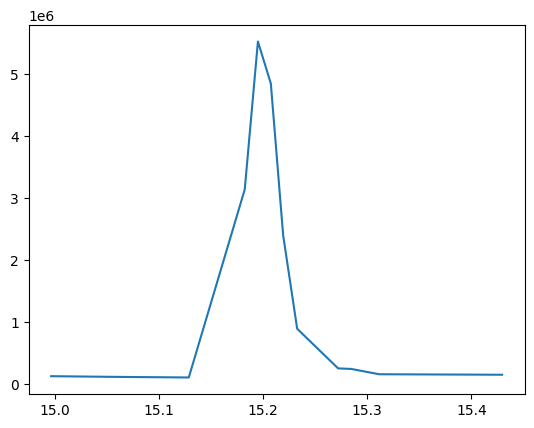

71


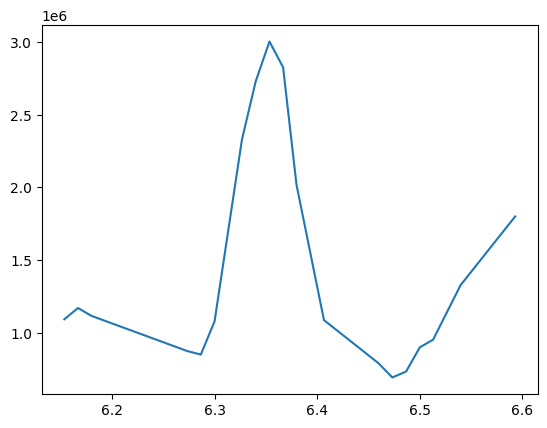

In [38]:
## NeatMS
# Set the threshold to 0.22
threshold=0.22
# Run the prediction
nn_handler.predict_peaks(threshold)

# Exploring results
exp = experiment
hq_sizes = []
lq_sizes = []
n_sizes = []
sizes = []
print("# Feature collection:",len(exp.feature_tables[0].feature_collection_list))
for consensus_feature in exp.feature_tables[0].feature_collection_list:
    hq_size = 0
    lq_size = 0
    n_size = 0
    for feature in consensus_feature.feature_list:
        for peak in feature.peak_list:
            if peak.valid:
                if peak.prediction.label == "High_quality":
                    hq_size += 1
                if peak.prediction.label == "Low_quality":
                    lq_size += 1
                if peak.prediction.label == "Noise":
                    n_size += 1

    hq_sizes.append(hq_size)
    lq_sizes.append(lq_size)
    n_sizes.append(n_size)
    sizes.append(len(consensus_feature.feature_list))

c = Counter(hq_sizes)
print("\nNumber of consensus features labeled as 'High quality':")
for size, count in c.most_common():
    print("   of size %2d : %6d" % (size, count))
print("        total : %6d" % len(exp.feature_tables[0].feature_collection_list))

c = Counter(lq_sizes)
print("\nNumber of consensus features labeled as 'Low quality':")
for size, count in c.most_common():
    print("   of size %2d : %6d" % (size, count))
print("        total : %6d" % len(exp.feature_tables[0].feature_collection_list))

c = Counter(n_sizes)
print("\nNumber of consensus features labeled as 'Noise':")
for size, count in c.most_common():
    print("   of size %2d : %6d" % (size, count))
print("        total : %6d" % len(exp.feature_tables[0].feature_collection_list))

# Export results
filename = 'sync/Output/neatms_export.csv'

export_params = {
    "export_classes" : ["High_quality", "Low_quality", "Noise"],
    "min_group_classes" : ["High_quality", "Low_quality", "Noise"],
    "min_group_size" : 0
}

experiment.export_csv(filename, **export_params)

In [40]:
%%R
## CAMERA
# Convert 'XcmsExperiment' to xset class
xset <- as(sample_data, "xcmsSet")

#CAMERA
#Create an xsAnnotate object
xsa <- xsAnnotate(xset)
#Group after RT value of the xcms grouped peak
xsaF <- groupFWHM(xsa, perfwhm=0.6)
#Verify grouping
xsaC <- groupCorr(xsaF)
#Annotate isotopes, could be done before groupCorr
xsaFI <- findIsotopes(xsaC)
#Annotate adducts
xsaFA <- findAdducts(xsaFI, polarity="positive")
#Get final peaktable and store on harddrive
write.csv(getPeaklist(xsaFA),file="sync/Output/result_CAMERA.csv")

Start grouping after retention time.
Created 532 pseudospectra.
Start grouping after correlation.
Generating EIC's .. 

Calculating peak correlations in 532 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  

Calculating graph cross linking in 532 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  
New number of ps-groups:  1838 
xsAnnotate has now 1838 groups, instead of 532 
Generating peak matrix!
Run isotope peak annotation
 % finished: 10  20  30  40  50  60  70  80  90  100  
Found isotopes: 296 
Generating peak matrix for peak annotation!

Calculating possible adducts in 1838 Groups... 
 % finished: 10  20  30  40  50  60  70  80  90  100  


Note: you might want to set/adjust the 'sampclass' of the returned xcmSet object before proceeding with the analysis.


In [42]:
# Load the NeatMS results from csv.
neatms_results = pd.read_csv("sync/Output/neatms_export.csv")
neatms_results = neatms_results.drop(columns=["Unnamed: 0"])
neatms_results.rename(columns={"m/z": "mz", "retention time": "rt"}, inplace=True)

# Round m/z and rt columns to 7 decimal places, for coherence with CAMERA results.
neatms_results["rt"] = neatms_results["rt"].round(7)
neatms_results["mz"] = neatms_results["mz"].round(7)

# Load the CAMERA results from csv.
CAMERA_results = pd.read_csv("sync/Output/result_CAMERA.csv")
CAMERA_results.rename(columns={"Unnamed: 0": "feature ID", "X0":"blank", "X1":"extract", "X1.1":"I_blank", "X2":"I_extract"}, inplace=True)

# Round m/z and rt columns to 7 decimal places, for coherence with NeatMS results.
CAMERA_results["rt"] = CAMERA_results["rt"].round(7)
CAMERA_results["mz"] = CAMERA_results["mz"].round(7)
CAMERA_results["feature ID"] = (CAMERA_results["feature ID"] - 1)

# Merge the CAMERA and NeatMS results into a single dataframe.
results_merged = neatms_results.merge(CAMERA_results, on=["feature ID", "mz", "rt"], how="left")
results_merged.reset_index(drop=True, inplace=True)

print(f"Length CAMERA Results: {len(CAMERA_results)}")
print(f"Length NeatMS Results: {len(neatms_results)}")
print(f"Length Merged Results: {len(results_merged)}")


Length CAMERA Results: 3375
Length NeatMS Results: 2584
Length Merged Results: 2584

Merged Results:


,feature ID,sample,mz,rt,height,area,label,mzmin,mzmax,rtmin,rtmax,npeaks,blank,extract,ms_level,I_blank,I_extract,isotopes,adduct,pcgroup
0,1,extract,67.055061,74.878047,2.607430e+06,2.660030e+07,Low_quality,67.055061,67.055061,74.878047,74.878047,1,0,1,1,NaN,2.660030e+07,NaN,NaN,9
1,4,blank,69.034294,62.025639,1.050038e+06,8.017498e+07,Noise,69.034281,69.034307,60.898777,63.152501,2,1,1,1,8.017498e+07,7.903664e+06,NaN,NaN,841
2,5,extract,69.034278,79.021769,2.357368e+08,3.151122e+09,Low_quality,69.034278,69.034278,79.021769,79.021769,1,0,1,1,NaN,3.151122e+09,[1][M]+,NaN,11
3,6,extract,69.034271,114.080759,5.899713e+07,1.334261e+09,Noise,69.034271,69.034271,114.080759,114.080759,1,0,1,1,NaN,1.334261e+09,NaN,[2M+2Na+K]3+ 61.0877,72
4,7,blank,69.034271,211.915501,6.229427e+05,1.553033e+07,Noise,69.034271,69.034271,211.915501,211.915501,1,1,0,1,1.553033e+07,NaN,NaN,NaN,451


In [ ]:
# Filter and select data:
results_selected = results_merged[results_merged["label"] == "High_quality"]        # Filter for "High_quality" labelled (NeatMS) peaks.
results_selected = results_selected[results_selected["extract"] == 1]               # Filter for peaks present in the extract sample.
results_selected = results_selected.sort_values(by="I_extract", ascending=False)    # Sort by intensity in the extract sample.

# Generate boolean Series for samples where peak in blank is > 10% of peak in extract.
blank_exceeds_10pc = (results_selected["blank"] == 1) & (results_selected["extract"] == 1) & (results_selected["I_extract"] < (results_selected["I_blank"] * 10)) 
blank_exceeds_10pc_inverted = ~blank_exceeds_10pc                                   # Invert the boolean Series
results_selected = results_selected[blank_exceeds_10pc_inverted]                    # Filter out peaks where blank is > 10% of extract

results_selected = results_selected.iloc[:]                                         # Select top all peaks by intensity

# Format feature ID list and pass to R environment.
feature_targets_py = results_selected["feature ID"]                                 # Extract feature target IDs

def add_leading_zeros(num):
    return str(num).zfill(4)

feature_targets_py = feature_targets_py.apply(add_leading_zeros)                    # Add leading zeros to feature target IDs in line with other XCMS objects.
feature_targets_py = "FT"+feature_targets_py                                        # Add 'FT' prefix to feature target IDs in line with other XCMS objects.
feature_targets_py = feature_targets_py.tolist()            
#feature_targets_py_out = feature_targets_py.copy()                                 # Create a copy of the feature target list for diagnostic purposes.
feature_targets_py = ro.StrVector(feature_targets_py)                               # Convert to R vector
ro.globalenv['feature_targets_R'] = feature_targets_py                              # Pass feature target list to R environment

In [ ]:
%%R
# Extract MS2 spectra, closest in RT to precursor peak apex, for the selected features.
ms2_spectra_selected <- featureSpectra(sample_data, msLevel = 2L, features = feature_targets_R, method = "closest_rt")
print(head(ms2_spectra_selected))
first_spectrum <- ms2_spectra_selected[1]
print(spectraData(first_spectrum))

# Export the selected MS2 spectra to an MGF file.
library(MsBackendMgf)
export(
  ms2_spectra_selected,
  MsBackendMgf(),
  file = "sync/Output/extract_MS2_spectra_FULL.mgf"
)

MSn data (Spectra) with 6 spectra in a MsBackendMzR backend:
    msLevel     rtime scanIndex
  <integer> <numeric> <integer>
1         2   869.469      5992
2         2   987.012      6872
3         2  1733.381     12518
4         2   914.161      6327
5         2   987.213      6874
6         2   963.098      6692
 ... 35 more variables/columns.

file(s):
blank.mzXML
Processing:
 Filter: select MS level(s) 2 [Wed Jan 29 21:50:31 2025]
 Merge 2 Spectra into one [Wed Jan 29 21:50:32 2025] 
DataFrame with 1 row and 36 columns
    msLevel     rtime acquisitionNum scanIndex   dataStorage    dataOrigin
  <integer> <numeric>      <integer> <integer>   <character>   <character>
1         2   869.469           5992      5992 /home/dock... /home/dock...
  centroided  smoothed  polarity precScanNum precursorMz precursorIntensity
   <logical> <logical> <integer>   <integer>   <numeric>          <numeric>
1       TRUE        NA         1        5989     585.495            2743147
  precursorCharge

In [252]:
# Import query and reference spectra.
references = list(load_from_mgf("sync/Spectral_Databases/20250125_ALL_GNPS.mgf"))
queries = list(load_from_mgf("sync/Output/extract_MS2_spectra_FULL.mgf"))

# Filter GNPS database to only include positive ion mode spectra.
references_pos = []
for spectrum in references:
    spectrum = require_correct_ionmode(spectrum, ion_mode_to_keep='positive')
    if spectrum is not None:
        references_pos.append(spectrum)

In [253]:
# Define the similarity function.
similarity_function = CudaCosineGreedy(
    tolerance=0.001,  # Same parameters as CosineGreedy
    mz_power=0,
    intensity_power=1,
    shift=0,
    ## CUDA-specific parameters!
    ## Controls the number of reference/queries to process in one step
    # larger batch sizes might speed up processing if GPU has enough memory
    batch_size=1024,
    # We need to trim any spectra with many peaks to maximum of `n_max_peaks`
    # shorter spectra aren't affected.
    n_max_peaks=1024,
    # Match limit is the number of possible pairs we accumulate before peak deduplication
    # In practice, match limits over 2k have negligible accuracy improvement.
    match_limit=2048,
    # Only used when array_type is 'sparse'. With sparse, we discard all scores
    # that are smaller than `sparse_threshold`. This allows us to save RAM memory
    # from overflowing when processing pairs on the order of ~1e+10.
    sparse_threshold=0.75,
)

# Calculate scores, spectra matching.
spectrum_scores = calculate_scores(                     
  references=references_pos,
  queries=queries,
  similarity_function=similarity_function, 
)

In [254]:
# Filter for precursor m/z matches within +-0.001
pc_matched = []

for query in queries:
    scores_output = spectrum_scores.scores_by_query(query, name="CudaCosineGreedy_score", sort=True)[:]
    for hit in scores_output:
        ref_pc_mz = np.round(hit[0].get("precursor_mz"), 6)       
        q_pc_mz = np.round(query.get("precursor_mz"), 6)
        if (ref_pc_mz >= q_pc_mz - 0.001) & (ref_pc_mz <= q_pc_mz + 0.001):
            pc_matched.append([hit, query])
        else:
            pass

In [255]:
# Extract the relevant information from the precursor+spectra matched hits.
results_assigned = []
for (hit, score), query in pc_matched:
    results_assigned.append({
        "Query feature ID": query.metadata['feature_id'],
        "Query scan id": query.metadata['scans'],
        "Reference scan id": hit.metadata['scans'],
        "Query precursor m/z": query.metadata['precursor_mz'],
        "Reference precursor_mz": hit.get("precursor_mz"),  
        "Score": score[0],
        "Number of matching peaks": score[1],
        "name": hit.get("compound_name"),
        "smiles": hit.get("smiles"),
        "charge": hit.get("charge"),
        "ms_level": hit.get("ms_level"),
        "Did GPU overflow": score[2]
    })

# Convert the results to a pandas DataFrame.
results_assigned_df = pd.DataFrame(results_assigned)

In [256]:
# Drop hits below a score of 80%
results_assigned_df_80 = results_assigned_df[results_assigned_df["Score"] >= 0.80]

In [294]:
FT2096 = []

# Find the target compound in the results data.
for (hit, score), query in pc_matched:
    if query.metadata['feature_id'] == "FT2096":
        FT2096.append([[hit, score], query])
    else:
        pass
    
# Display some summary information for the target compound hits.
print(f"{len(FT2096)} hits found for FT2096")   
print("Precursor m/z:", FT2096[0][1].metadata['precursor_mz'])
print("MS2 RT:", FT2096[0][1].metadata['retention_time'])

# Extract relevant information from the FT2096 hits.
FT2096_results = []
for (hit, score), query in FT2096:
    FT2096_results.append({
        "Query feature ID": query.metadata['feature_id'],
        "Query scan id": query.metadata['scans'],
        "Reference scan id": hit.metadata['scans'],
        "Query precursor m/z": query.metadata['precursor_mz'],
        "Reference precursor_mz": hit.get("precursor_mz"),  
        "Score": score[0],
        "Number of matching peaks": score[1],
        "name": hit.get("compound_name"),
        "smiles": hit.get("smiles"),
        "charge": hit.get("charge"),
        "ms_level": hit.get("ms_level"),
        "Did GPU overflow": score[2]
    })

# Convert the results to a pandas DataFrame.
FT2096_results_df = pd.DataFrame(FT2096_results)

# Drop hits below a score of 80%
FT2096_results_df_80 = FT2096_results_df[FT2096_results_df["Score"] >= 0.80]

# Display top 5 hits.
display(FT2096_results_df_80.head())

50 hits found for FT2096
Precursor m/z: 298.096650065991
MS2 RT: 329.738512463555


,Query feature ID,Query scan id,Reference scan id,Query precursor m/z,Reference precursor_mz,Score,Number of matching peaks,name,smiles,charge,ms_level,Did GPU overflow
0,FT2096,2049,16990,298.09665,298.097,0.998802,12,MeSAdo CollisionEnergy:205060 M+H,CSCC1OC(n2cnc3c(N)ncnc32)C(O)C1O,1,2,False
1,FT2096,2049,17216,298.09665,298.097,0.998731,12,Methylthioadenosine CollisionEnergy:205060 M+H,CSCC1OC(n2cnc3c(N)ncnc32)C(O)C1O,1,2,False
2,FT2096,2049,34428,298.09665,298.096,0.998082,12,Suspect related to Massbank:EQ330404 Adenosine...,None,1,2,False
3,FT2096,2049,40669,298.09665,298.097,0.997880,12,Methylthioadenosine [M+H]+,CSC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@...,1,2,False
4,FT2096,2049,7488,298.09665,298.097,0.997875,12,Methylthioadenosine M+H,CSC[C@H]1O[C@@H](n2cnc3c(N)ncnc32)[C@H](O)[C@@...,1,2,False


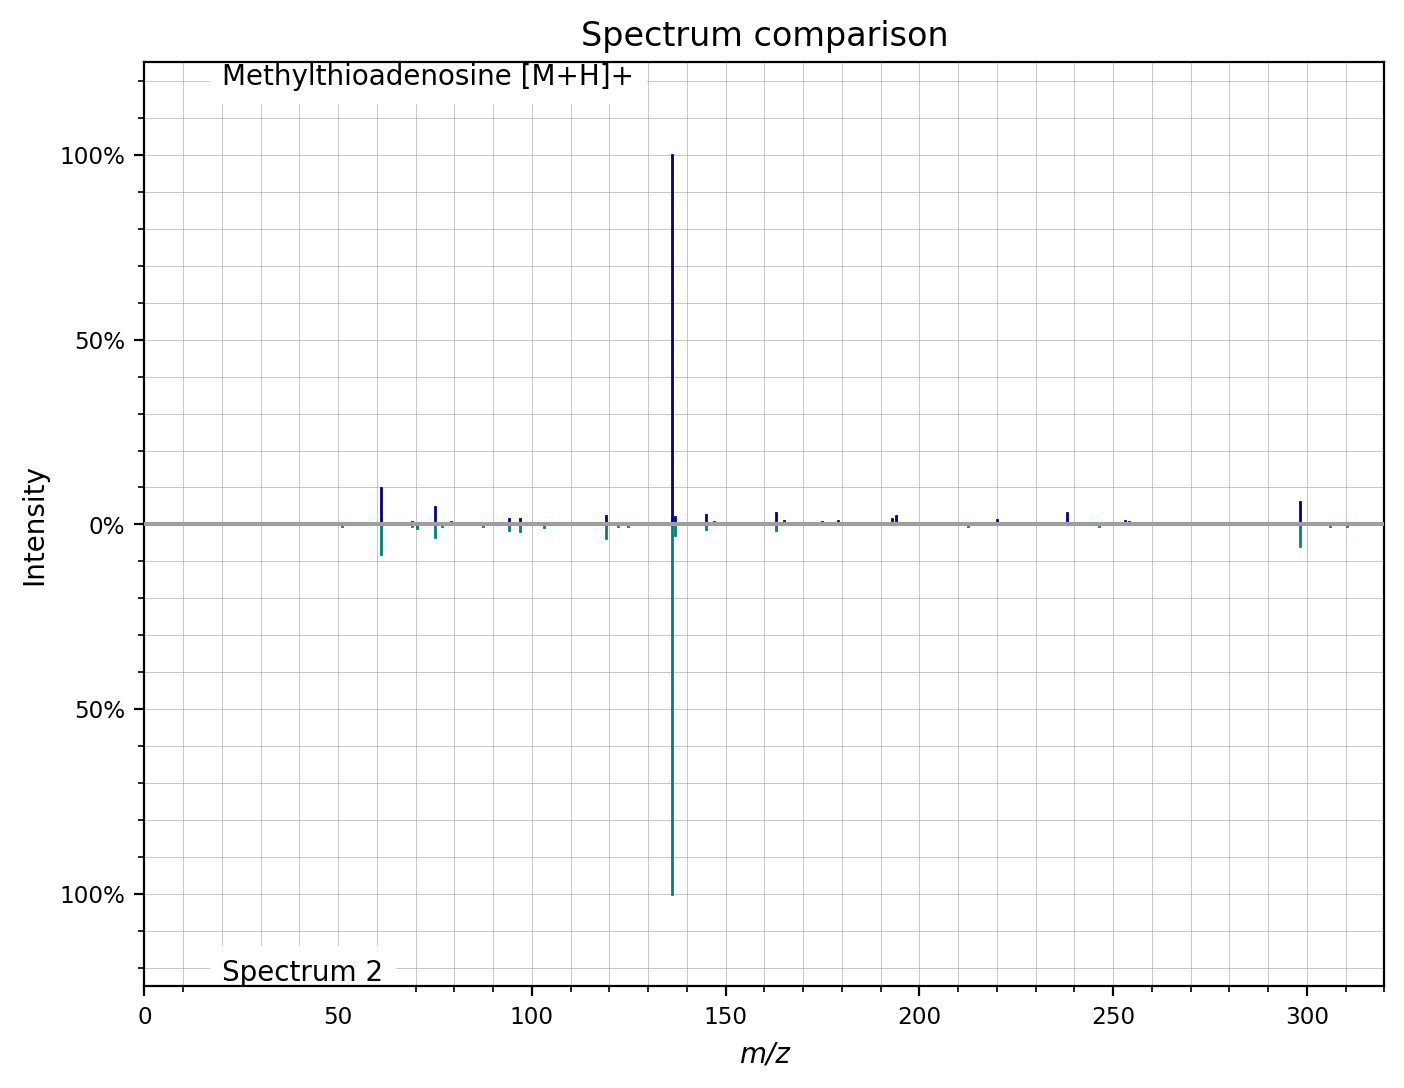

In [327]:
fig = FT2096[3][0][0].plot_against(FT2096[0][1], annotate_ions=True)
plt.xlim(0, 320)
plt.show()